<div style="padding: 20px; border-radius: 15px; color: #1e1e2f; font-family: Arial, sans-serif; width: fit-content;">
    <span style="color: #ffa500; font-size: 20px; font-weight: bold;">
        Deep Learning 1 Project - Group 5:<br>
        Tweet Sentiment Extraction (Kaggle · Featured Code Competition)<br><br>
    </span>
    <span style="font-size: 18px; line-height: 1.6;">
        <strong>Chaoyu Liu</strong> (101573622)<br>
        <strong>Devanshi Dave</strong> (101582208)<br>
        <strong>Dwip Makwana</strong> (101483523)<br>
        <strong>Eric Lessa</strong> (101549935)<br>
        <strong>Moossa Hussain</strong> (101542820)<br>
        <strong>Rutika Bhuva</strong> (101551781)<br>
        <strong>Sam Emami</strong> (101575471)<br>
        <strong>Shrey Patel</strong> (101541370)<br>    
    </span>
</div>


In [1]:
# Necessary dependency installations
!pip install shap
!pip install transformers
!pip install pipeline
!pip install datasets
!pip show torchvision
!pip install evaluate

#go to https://graphviz.gitlab.io/download/ and install graphviz

Name: torchvision
Version: 0.20.1+cu121
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, pillow, torch
Required-by: easyocr, fastai, timm
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.4 MB/s eta 0:00:00


#### 1. Exploratory Data Analysis (EDA)
---

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None

Missing Values:
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


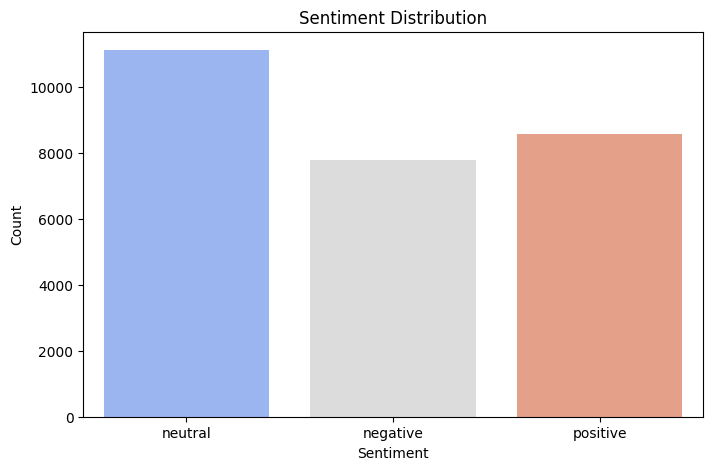

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


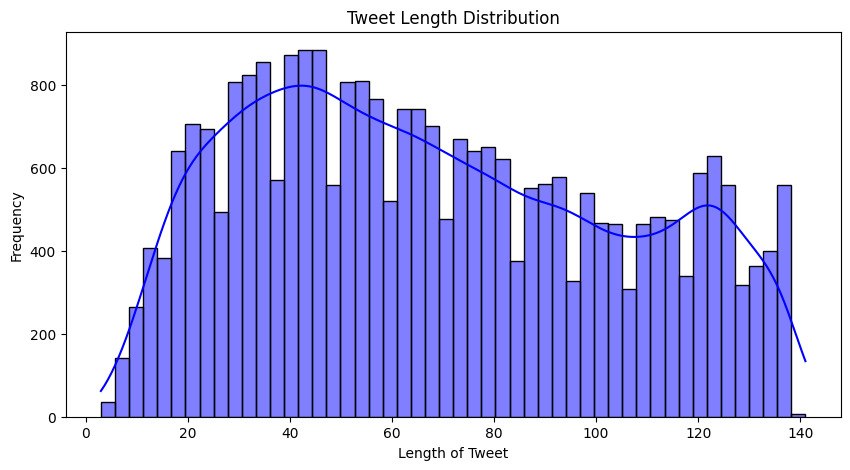

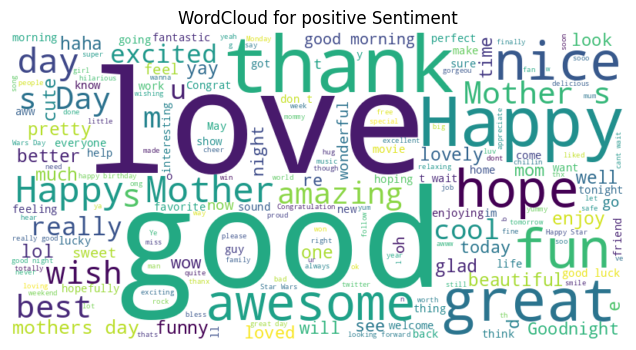

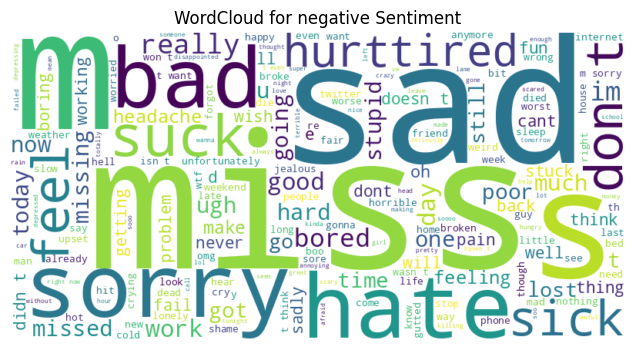

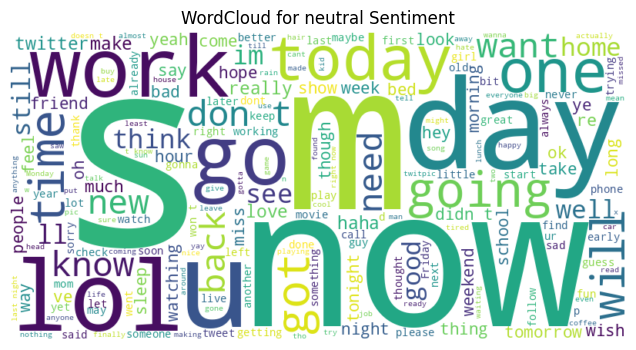

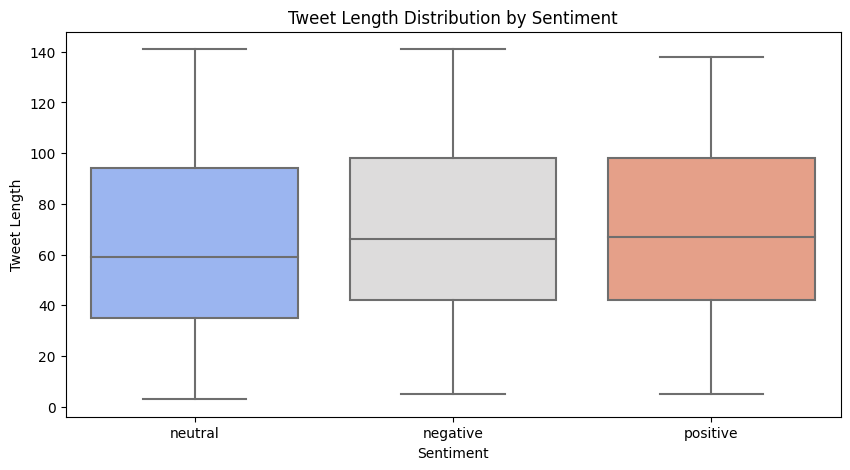


Sample Data:
       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  text_length  
0  I`d have responded, if I were going   neutral           36  
1                             Sooo SAD  negative           46  
2                          bullying me  negative           25  
3                       leave me alone  negative           31  
4                        Sons of ****,  negative           75  


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Load dataset
df = pd.read_csv("/kaggle/input/tweet-extraction-train/train.csv")

# Display basic info
print("Dataset Overview:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Drop rows with missing text or selected_text
df.dropna(subset=['text', 'selected_text'], inplace=True)

# Sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment', palette='coolwarm')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Tweet length distribution
df["text_length"] = df["text"].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df["text_length"], bins=50, kde=True, color="blue")
plt.title("Tweet Length Distribution")
plt.xlabel("Length of Tweet")
plt.ylabel("Frequency")
plt.show()

# Word clouds for each sentiment
def generate_wordcloud(sentiment):
    text = " ".join(df[df["sentiment"] == sentiment]["selected_text"].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment} Sentiment")
    plt.show()

for sentiment in ["positive", "negative", "neutral"]:
    generate_wordcloud(sentiment)

# Boxplot for text length distribution per sentiment
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["sentiment"], y=df["text_length"], palette="coolwarm")
plt.title("Tweet Length Distribution by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Length")
plt.show()

# Display first few rows for verification
print("\nSample Data:")
print(df.head())


#### **<span style="color: goldenrod;">Hugging Face Transformers Tools for Using Pre-trained LLMs:</span>**

**<span style="color: goldenrod;">Pipeline:</span>**  
It is like a convenient wrapper or helper that simplifies the process of working with models such as those loaded with **AutoModelForSequenceClassification** and their associated tokenizers.  
It integrates with pre-trained models and tokenizers for specific tasks and performs NLP tasks with the following processes:  
- Loading the model  
- Tokenizing the input text  
- Generating predictions  
- Post-processing the output (if necessary)  

---

**<span style="color: goldenrod;">AutoModelForSequenceClassification:</span>**  
Loading Pre-trained Models designed for sequence classification tasks. Sequence Classification refers to tasks where you classify an entire sequence of text (like a sentence or document) into a category. Examples include:  
- **<span style="color: red;">Sentiment analysis (positive, negative, neutral)</span>**  
- Topic classification (news, sports, politics)  
- Spam detection  
- Intent classification (e.g., order, question, complaint)  

**"Auto" in the Name:** The **Auto** prefix in the class name signifies its flexibility. You can use it to load various pre-trained models from different architectures (**BERT**, **RoBERTa**, **DistilBERT**, etc.) simply by specifying the model name or path.

---

**<span style="color: goldenrod;">AutoTokenizer:</span>**  
Tokenizes the inputs. The tokenizer ensures that:  
- The tokenized input matches the vocabulary and format expected by the model.  
- The inputs include features like `input_ids`, `attention_mask`, and `token_type_ids` (if applicable).


In [3]:
import os
import pandas as pd
import shap
import numpy as np
import torch
from datasets import Dataset
import evaluate
from transformers import EarlyStoppingCallback
from transformers import EvalPrediction
from transformers import (
    pipeline,
    AutoModelForSequenceClassification,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    pipeline,
    DefaultDataCollator,
    DataCollatorWithPadding,
    AutoTokenizer
)

In [4]:
import wandb

import os

#wandb.finish()

# Set your API key from wandb
os.environ["WANDB_API_KEY"] = "e487d3088678f5756edd7723c12b638fbb9b742f"

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ericrlessa (ericrlessa-george-brown-college). Use `wandb login --relogin` to force relogin


True

In [5]:
wandb.init(
    settings=wandb.Settings(init_timeout=120),
    project="tweet_span_sentiment_extraction"
)

#### 2. Data Preprocessing, Fine-tuning, Prediction, Evaluation and Metrics Calculation

In [6]:
class SentimentExtraction:
    """
    A class for performing sentiment extraction using pre-trained BERT-based models from Hugging Face Transformers and fine-tuning them.

    Attributes:
        train_df (DataFrame): DataFrame containing the training data loaded from the specified CSV file.
        tokenizer (AutoTokenizer): Tokenizer associated with the pre-trained model.
        model (AutoModelForQuestionAnswering): Pre-trained model for question answering tasks.
        squad_metric (evaluate.EvaluationModule): Evaluation module for computing SQuAD metrics.
        test_dataset (Dataset): Dataset for testing the model.
    """
    def __init__(self, train_path):
        """
        Initialize the SentimentExtraction class.

        Args:
            train_path (str): Path to the training CSV file.
        """
        self.train_df = pd.read_csv(train_path)
        self.tokenizer = None
        self.model = None
        self.squad_metric = evaluate.load("squad")
        self.test_dataset = None

    def prepare_data(self):
        """
        Clean and prepare the data for training and evaluation.

        Returns:
            Tuple[Dataset, Dataset]: Returns the training and validation datasets.
        """
        
        self.train_df = self.train_df.dropna(subset=['text'])
        
        dataset = Dataset.from_pandas(self.train_df)
        split_data = dataset.train_test_split(test_size=0.1, seed=42)

        train_dataset = split_data['train']
        self.test_dataset = split_data['test']

        train_val_dataset = train_dataset.train_test_split(test_size=0.1, seed=42)

        train_dataset = train_val_dataset['train']
        val_dataset = train_val_dataset['test']
        
        return train_dataset, val_dataset

    def setup_model(self, model_name):
        """
        Initialize the model and tokenizer from the specified model name.

        Args:
            model_name (str): Name or path of the pre-trained model.
        """
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForQuestionAnswering.from_pretrained(model_name)
        
        # Move model to available device
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(device)

    def tokenize_question_context(self, examples):
        """
        Tokenize the sentiment and text for question-answering.

        Args:
            examples (dict): Dictionary containing 'sentiment', 'text', and 'selected_text'.

        Returns:
            dict: Tokenized input with start and end positions for the answer span.
        """
        sentiment = examples['sentiment']
        tweet = examples['text']
        span = examples['selected_text']

        tokenized_qa = self.tokenizer(sentiment, # question
                                tweet, # context
                                padding='max_length',
                                return_offsets_mapping=True)

        tokenized_qa["start_positions"] = []
        tokenized_qa["end_positions"] = []

        start_char = tweet.find(span)
        end_char = start_char + len(span)

        offsets = tokenized_qa.pop("offset_mapping")
        start_token = end_token = None
        for idx, (start, end) in enumerate(offsets):
            if start <= start_char < end:
                start_token = idx
            if start < end_char <= end:
                end_token = idx
                break

        tokenized_qa["start_positions"].append(start_token)
        tokenized_qa["end_positions"].append(end_token)

        if start is None or end is None:
            raise ValueError("Data set error: Could not identify start/end for span/context.")

        return tokenized_qa

    def compute_metrics(self, eval_pred):
        """
        Compute evaluation metrics including exact match, F1 score, and Jaccard index.

        Args:
            eval_pred (Tuple): Tuple containing predictions and labels.

        Returns:
            dict: Dictionary with exact match, F1 score, and average Jaccard index.
        """
        predictions, labels = eval_pred
        start_preds, end_preds = predictions  # Unpack start and end logits
        start_labels, end_labels = labels     # Unpack start and end positions

        # Convert logits to predicted indices
        start_preds = np.argmax(start_preds, axis=1)  # Shape: (100,)
        end_preds = np.argmax(end_preds, axis=1)      # Shape: (100,)

        total_jaccard = 0
        num_samples = len(start_preds)

        # Create prediction and reference text spans
        preds = []
        refs = []
        for i in range(len(start_preds)):
            # Decode predicted text span
            pred_tokens = self.tokenizer.decode(range(start_preds[i], end_preds[i] + 1))            
            preds.append({"id": str(i), "prediction_text": pred_tokens})
            
            # Decode reference text span
            ref_tokens = self.tokenizer.decode(range(start_labels[i, 0], end_labels[i, 0] + 1))
            refs.append({"id": str(i), "answers": {"text": [ref_tokens], "answer_start": [start_labels[i, 0]]}})

            jaccard = SentimentExtraction.jaccard_tokens(pred_tokens, ref_tokens)
            total_jaccard += jaccard

        avg_jaccard = total_jaccard / num_samples

        # Compute SQuAD metrics
        squad_result = self.squad_metric.compute(predictions=preds, references=refs)

        return {
            "exact_match": f"{squad_result['exact_match']:.2f}%",
            "f1_score": f"{squad_result['f1']:.2f}%",
            "avg_jaccard": f"{avg_jaccard:.2f}"
        }

    @staticmethod
    def jaccard_tokens(pred_tokens, ref_tokens):
        """
        Compute Jaccard similarity between predicted and reference tokens.

        Args:
            pred_tokens (str): Predicted tokens.
            ref_tokens (str): Reference tokens.

        Returns:
            float: Jaccard similarity score.
        """
        pred_set = set(pred_tokens.lower().split())
        ref_set = set(ref_tokens.lower().split())
        intersection = pred_set.intersection(ref_set)
        union = pred_set.union(ref_set)
        jaccard = len(intersection) / len(union) if union else 0
        return jaccard

    def train(self, model_name, learning_rate, epochs, checkpoint=None):
        """
        Train the model with the given parameters.

        Args:
            model_name (str): Name of the pre-trained model.
            learning_rate (float): Learning rate for training.
            epochs (int): Number of epochs.
            checkpoint (str, optional): Path to a checkpoint for resuming training.
        """
        # Prepare data
        print("\nPreparing datasets...")
        print("Dataset columns:", self.train_df.columns.tolist())
        train_dataset, eval_dataset = self.prepare_data()
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Eval dataset size: {len(eval_dataset)}")

        # Setup model
        print("\nSetting up model...")
        self.setup_model(model_name)

        tokenized_train = train_dataset.map(self.tokenize_question_context)

        tokenized_eval = eval_dataset.map(self.tokenize_question_context)

        print(f"\nSelecting {tokenized_train} training samples and {tokenized_eval} evaluation samples...")

        args = TrainingArguments(
            f"finetune-BERT-tweet",
            evaluation_strategy = "epoch",
            learning_rate=learning_rate,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=epochs,
            weight_decay=0.01,
            save_total_limit=2,
            fp16=True
        )


        trainer = Trainer(
            model=self.model,
            args=args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_eval,
            data_collator=DataCollatorWithPadding(self.tokenizer),
            tokenizer=self.tokenizer,
            compute_metrics=self.compute_metrics
        )

        # Train model
        print("\nStarting training...")
        try:
            trainer.train(resume_from_checkpoint=checkpoint)
            print("\nTraining completed successfully!")
        except Exception as e:
            print(f"\nError during training: {str(e)}")
            return
        

    def train_multiple_models(self, model_configs):
        """
        Train multiple models with specified configurations and compare results.

        Args:
            model_configs (list): List of dictionaries with model configurations.
        """
        results = []
        
        for config in model_configs:
            model_name = config["model_name"]
            learning_rate = config["learning_rate"]
            epochs = config["epochs"]
            
            print(f"\nTraining model: {model_name}")
            self.train(model_name, learning_rate, epochs)
            metrics = self.evaluate_test_dataset()
            metrics["model"] = model_name
            results.append(metrics)
            
            # Save model
            self.model.save_pretrained(f"sentiment_extraction_{model_name.replace('/', '_')}")

        # Print performance comparison
        print("\nModel Performance Comparison:")
        for res in results:
            print(f"\nModel: {res['model']}")
            print(f"Exact Match: {res['exact_match']}")
            print(f"F1 Score: {res['f1_score']}")
            print(f"Avg Jaccard: {res['avg_jaccard']}")
    
    def baseline(self):
        dataset, _ = self.prepare_data()
        self.compute_metrics_for_dataset(dataset)

    def evaluate_test_dataset(self):
        """
        Evaluate the model on the test dataset.

        Returns:
            dict: Evaluation metrics including exact match, F1 score, and average Jaccard index.
        """
        print('\nEvaluating the test dataset at the end of training...')
        if not self.test_dataset:
            print("Test dataset is empty or not available.")
            return {"exact_match": 0.0, "f1_score": 0.0, "avg_jaccard": 0.0}
        
        total_jaccard = 0
        preds = []
        refs = []
        for i in range(len(self.test_dataset)):
            sample = self.test_dataset[i]
            sentiment = sample['sentiment']
            tweet = sample['text']
            span = sample['selected_text']
    
            with torch.no_grad():
                pred_text = self.predict_span(sentiment, tweet)

                preds.append({"id": str(i), "prediction_text": pred_text})
                refs.append({"id": str(i), "answers": {"text": [span], "answer_start": [tweet.find(span)]}})

                total_jaccard += SentimentExtraction.jaccard_text(pred_text, span)
        
        squad_result = self.squad_metric.compute(predictions=preds, references=refs)
        return {
            "exact_match": float(squad_result['exact_match']),
            "f1_score": float(squad_result['f1']),
            "avg_jaccard": float(total_jaccard/len(self.test_dataset))
        }

    def compute_metrics_for_dataset(self, dataset):
        total_jaccard = 0
        preds = []
        refs = []
        for i in range(len(dataset)):
            sample = dataset[i]
            sentiment = sample['sentiment']
            tweet = sample['text']
            span = sample['selected_text']
    
            with torch.no_grad():
                pred_text = self.predict_span(sentiment, tweet)

                preds.append({"id": str(i), "prediction_text": pred_text})
                refs.append({"id": str(i), "answers": {"text": [span], "answer_start": [tweet.find(span)]}})

                total_jaccard += SentimentExtraction.jaccard_text(pred_text, span)
        
        squad_result = self.squad_metric.compute(predictions=preds, references=refs)
        print("Prediction results:")
        print(f"\texact_match: {squad_result['exact_match']:.2f}%")
        print(f"\tf1_score: {squad_result['f1']:.2f}%")
        print(f"\tavg_jaccard: {total_jaccard/len(dataset):.2f}")

    def predict_span(self, sentiment,tweet):
        """
        Predict the span of text related to sentiment.

        Args:
            sentiment (str): The sentiment label (e.g., positive, negative).
            tweet (str): The tweet text.

        Returns:
            str: Predicted span of text.
        """
        inputs = self.tokenizer(
                sentiment,  # the sentiment question
                tweet,      # the tweet context
                padding=True,
                truncation=True,
                return_tensors="pt"
        )
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        outputs = self.model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        
        start_position = torch.argmax(start_logits, dim=-1)
        end_position = torch.argmax(end_logits, dim=-1)
        
        tokens = self.tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
                
        pred_span_tokens = tokens[start_position:end_position+1]
        pred_text = self.tokenizer.convert_tokens_to_string(pred_span_tokens)
        return pred_text

    @staticmethod
    def jaccard_text(text, span):
        """
        Compute Jaccard similarity between predicted text and actual span.

        Args:
            text (str): Predicted text.
            span (str): Actual text span.

        Returns:
            float: Jaccard similarity score.
        """
        set1 = set(text.lower().split())
        set2 = set(span.lower().split())
        jaccard = len(set1 & set2) / len(set1 | set2)  # Intersection / Union
        return jaccard


In [13]:
def zip_and_download_models(self):
        """Zip all trained models and provide a link to download them"""
        zip_filename = "trained_models.zip"
        shutil.make_archive("trained_models", 'zip', ".")
        print(f"Models zipped successfully: {zip_filename}")
        
        from IPython.display import FileLink
        return FileLink(zip_filename)

In [9]:
def main(dataset_path='/kaggle/input/tweet-extraction-train/train.csv'):
    # Initialize processor
    print("Initializing data processor...")
    processor = SentimentExtraction(dataset_path)
    
    model_configs = [
        {"model_name": "distilbert-base-uncased", "learning_rate": 2e-5, "epochs": 3},
        {"model_name": "bert-base-uncased", "learning_rate": 3e-5, "epochs": 5},
        {"model_name": "roberta-base", "learning_rate": 1e-5, "epochs": 4}
    ]
    
    processor.train_multiple_models(model_configs)

    return processor

def print_baseline(dataset_path='/kaggle/input/tweet-extraction-train/train.csv'):
    # Initialize processor
    print("Initializing data processor...")
    processor = SentimentExtraction(dataset_path)

    model_name = "distilbert-base-uncased"
    processor.setup_model(model_name)
    processor.baseline()

def prediction_test(processor):
    tweet = " you guys didn`t say hi or answer my questions yesterday  but nice songs."
    sentiment = "positive"

    sentiment_text = processor.predict_span(sentiment, tweet)

    print(f"Predicted sentiment span: {sentiment_text}")

In [10]:
print_baseline()

Initializing data processor...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Prediction results:
	exact_match: 0.49%
	f1_score: 8.82%
	avg_jaccard: 0.06


In [11]:
processor = main()

Initializing data processor...

Training model: distilbert-base-uncased

Preparing datasets...
Dataset columns: ['textID', 'text', 'selected_text', 'sentiment']
Train dataset size: 22258
Eval dataset size: 2474

Setting up model...


Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22258 [00:00<?, ? examples/s]

Map:   0%|          | 0/2474 [00:00<?, ? examples/s]


Selecting Dataset({
    features: ['textID', 'text', 'selected_text', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 22258
}) training samples and Dataset({
    features: ['textID', 'text', 'selected_text', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 2474
}) evaluation samples...


`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Starting training...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Exact Match,F1 Score,Avg Jaccard
1,1.032900,0.972376,51.37%,71.52%,0.67
2,0.856100,0.941344,54.89%,73.21%,0.69
3,0.757500,0.959545,54.12%,73.35%,0.69



Training completed successfully!

Evaluating the test dataset at the end of training...

Training model: bert-base-uncased

Preparing datasets...
Dataset columns: ['textID', 'text', 'selected_text', 'sentiment']
Train dataset size: 22258
Eval dataset size: 2474

Setting up model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Parameter 'function'=<bound method SentimentExtraction.tokenize_question_context of <__main__.SentimentExtraction object at 0x7d6b6c0fbdf0>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/22258 [00:00<?, ? examples/s]

Map:   0%|          | 0/2474 [00:00<?, ? examples/s]


Selecting Dataset({
    features: ['textID', 'text', 'selected_text', 'sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 22258
}) training samples and Dataset({
    features: ['textID', 'text', 'selected_text', 'sentiment', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 2474
}) evaluation samples...

Starting training...


`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Epoch,Training Loss,Validation Loss,Exact Match,F1 Score,Avg Jaccard
1,1.005800,0.966937,51.86%,72.61%,0.68
2,0.790400,0.949681,55.78%,73.76%,0.69
3,0.624800,1.046725,53.52%,73.85%,0.69
4,0.464300,1.209296,53.64%,74.09%,0.69
5,0.339600,1.357435,53.60%,74.05%,0.69



Training completed successfully!

Evaluating the test dataset at the end of training...

Training model: roberta-base

Preparing datasets...
Dataset columns: ['textID', 'text', 'selected_text', 'sentiment']
Train dataset size: 22258
Eval dataset size: 2474

Setting up model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22258 [00:00<?, ? examples/s]

Map:   0%|          | 0/2474 [00:00<?, ? examples/s]


Selecting Dataset({
    features: ['textID', 'text', 'selected_text', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 22258
}) training samples and Dataset({
    features: ['textID', 'text', 'selected_text', 'sentiment', '__index_level_0__', 'input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 2474
}) evaluation samples...

Starting training...


`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.


Epoch,Training Loss,Validation Loss,Exact Match,F1 Score,Avg Jaccard
1,1.075300,0.929769,56.83%,66.15%,0.65
2,0.869400,0.866869,60.71%,68.58%,0.68
3,0.794800,0.872281,59.66%,68.54%,0.68
4,0.759600,0.869870,60.79%,69.52%,0.69



Training completed successfully!

Evaluating the test dataset at the end of training...

Model Performance Comparison:

Model: distilbert-base-uncased
Exact Match: 37.04512372634643
F1 Score: 67.27656686725193
Avg Jaccard: 0.5630550665925526

Model: bert-base-uncased
Exact Match: 36.098981077147016
F1 Score: 67.37174150679255
Avg Jaccard: 0.562081638751201

Model: roberta-base
Exact Match: 52.001455604075694
F1 Score: 70.20428295577787
Avg Jaccard: 0.6431049458925355


In [12]:
prediction_test(processor)

Predicted sentiment span:  but nice


In [23]:
import shutil
from IPython.display import FileLink

# Reload SentimentExtraction class and attach trained models
processor = SentimentExtraction('/kaggle/input/tweet-extraction/train.csv')

# Dynamically add zip_and_download_models method
def zip_and_download_models(self):
    """Zip all trained models and provide a link to download them"""
    zip_filename = "trained_models.zip"
    shutil.make_archive("trained_models", 'zip', ".")
    print(f"Models zipped successfully: {zip_filename}")
    return FileLink(zip_filename)

# Attach the method dynamically to SentimentExtraction class
SentimentExtraction.zip_and_download_models = zip_and_download_models


download_link = processor.zip_and_download_models()
print("Download your trained models here:", download_link)


Models zipped successfully: trained_models.zip
Download your trained models here: /kaggle/working/trained_models.zip


In [ ]:
def trainFromCheckpoint(checkpoint):
    # Initialize processor
    print("Initializing data processor...")
    processor = SentimentExtraction('/kaggle/input/tweet-extraction/train.csv')

    processor.train(checkpoint)


#trainFromCheckpoint('/kaggle/working/finetune-BERT-tweet/checkpoint-8000')

#### **<span style="color: goldenrod;">Model Acquisition:</span>**  
<span style="font-size: 16px;">From the Hugging Face Transformers library, acquires a pre-trained **BERT-based sentiment analysis model** (**LLM**), with its appropriate **pipeline** (**classifier**) and **tokenizer**.</span>


### Predictions sentiment extraction

#### **<span style="color: goldenrod;">Important Note by Sam:</span>**  
<span style="font-size: 16px;">LLMs such as BERT, LLama, GPTT, etc., and BERT-based models (like distilbert-base-uncased-finetuned-sst-2-english) do not include an activation function (e.g., softmax or sigmoid) at their output layer by default. Instead, they output logits, which are raw, unnormalized scores for each class. The activation function, if needed, is applied externally depending on the specific task and requirements.<br> 
BERT is a general-purpose transformer model. By omitting the activation function, it can be fine-tuned for various tasks: Multi-class classification (e.g., softmax), Binary classification (e.g., sigmoid), Regression tasks (no activation function).<br></span>

---

#### **<span style="color: goldenrod;">outputs:</span>**  
<span style="font-size: 16px;">It is an object of type ModelOutput, specifically tailored for the model we are using. Here we didn't simply print the result of the sentiment for each tweet, but we used output.logits to access the detailed classification results for each text for further word-by-word analysis in SHAP.<br></span>

---

#### **<span style="color: goldenrod;">logits:</span>**  
<span style="font-size: 16px;">Logits are the model’s raw output before applying the activation function. Logits are unnormalized scores, which can be positive, negative, or zero, depending on the model’s confidence in each class. Here, "outputs.logits" is a tensor containing the raw, unnormalized predictions for each input sequence. Each row in the tensor corresponds to one input in texts, and each column corresponds to a class.<br></span>

---

#### **<span style="color: goldenrod;">Normalize logits to probabilities:</span>**  
<span style="font-size: 16px;">By applying softmax, we normalize the raw predictions for each tweet to probabilities (the results are printed for clarity).<br></span>

---

#### **<span style="color: goldenrod;">detach():</span>**  
<span style="font-size: 16px;">We use it since we don’t want to compute gradients for the tensor. Since probabilities are used only for prediction (not training), there’s no need to track gradients, so detach() avoids unnecessary computational overhead.<br></span>


In [ ]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
# Load pre-trained sentiment analysis model and tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
classifier = pipeline("sentiment-analysis", model=model_name)

# Tokenizer and model for SHAP
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
# Define a wrapper for the classifier to work with SHAP
def classifier_wrapper(texts):
    tokens = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")
    outputs = model(**tokens)
    probabilities = outputs.logits.softmax(dim=1).detach().numpy()
    print(f"\nlogits contains tweets' unnormalized prediction scores for each class(positive / negative):\n{outputs.logits}\n")
    return probabilities

# Select a subset of the training data for SHAP analysis
sample_texts = train_df["text"].sample(10, random_state=42).tolist()
print("Sample Texts:")
print(sample_texts)
print(f"Probibilities after normalizing logits by softwax:\n {classifier_wrapper(sample_texts)}")  # Should output a numpy array of probabilities


#### **<span style="color: goldenrod;">SHAP Analysis:</span>**  
<span style="font-size: 16px;">SHAP is based on <u>Shapley values</u>, which is a concept from <u>Game Theory</u>. Imagine a group of players collaborating to achieve a common goal. Shapley values determine how to fairly distribute the rewards or profits among the players based on their individual contributions.  
In the context of machine learning, features of a data point can be seen as "players" contributing to the model's prediction.<br>  
SHAP aims to fairly attribute the "credit" (or "blame") for the model's output to each feature.<br>  
For complex models, SHAP often uses <u>approximations</u> or <u>sampling techniques</u> to estimate Shapley values.<br>  
The explainer considers <u>all possible combinations of features (words or tokens)</u> in the sample.  
For each combination, it calculates the model's prediction.<br> This process helps determine how much each feature contributes to the overall prediction.  
Shapley Values are assigned based on the calculated predictions for different feature combinations, SHAP assigns a value to each feature.<br><br></span>

---

#### **<span style="color: goldenrod;">shap.Explainer:</span>**  
<span style="font-size: 16px;">Is the core class in the SHAP library. It encapsulates the model and the method for <u>calculating</u> SHAP values, which quantify the <u>contribution of each feature</u> (in this case, words or tokens) <u>to the model's prediction</u> for a given sample.<br> The Explainer needs the "classifier_wrapper" function to understand how the model makes predictions.<br><br></span>

---

#### **<span style="color: goldenrod;">Note:</span>**  
<span style="font-size: 16px;">When classifier_wrapper is run by SHAP, there are six or fewer probabilities for the ten tweets in sample_texts. This is because the tokenizer applies padding and truncation to the input. If multiple texts are identical, the tokenizer may return the same tokens for duplicates. If sample_texts contains duplicate or very similar tweets, their logits will be identical, and we might get fewer output tensors.<br><br></span>


In [ ]:

# Explain predictions using SHAP
# This line integrates the model in the function to SHAP and encapsulates
# the necessary information to compute SHAP values for the given model and data.
explainer = shap.Explainer(classifier_wrapper, tokenizer)
shap_values = explainer(sample_texts)

# Visualize the SHAP values for each word:
# Output 0 and Output 1: predicted probabilities for two classes
for i, text in enumerate(sample_texts):
    print(f"\nSHAP Analysis for Text {i + 1}: {text}")
    shap.plots.text(shap_values[i])
'''
#The following code save SHAP analysis results into different html files for each tweet:

#shap.save_html("shap_analysis.html", shap_values)
# Manually set the base value if explainer.expected_value is None
# For classification tasks, the base value can be the mean of logits
if explainer.expected_value is None:
    print("explainer.expected_value is None. Computing a manual base value.")
    base_value = np.mean([np.mean(values.values) for values in shap_values])
else:
    base_value = explainer.expected_value

# Loop through all SHAP values and save each as a separate force plot
for i, shap_value in enumerate(shap_values):
    # Debugging: Print base value and SHAP values
    print(f"Processing Text {i + 1}")
    print(f"Base Value: {base_value}")
    print(f"SHAP Values for Text {i + 1}: {shap_value.values}")

    # Check if shap_value.values is None
    if shap_value.values is None:
        print(f"Skipping Text {i + 1} due to missing values.")
        continue

    # Handle multi-output models (if applicable)
    if isinstance(base_value, list):
        base_value = base_value[0]  # Use the base value for the first output

    # Create a force plot for the current sample
    try:
        vis = shap.plots.force(base_value, shap_value.values)

        # Save the visualization as an HTML file
        file_name = f"shap_analysis_{i + 1}.html"
        shap.save_html(file_name, vis)
        print(f"Saved SHAP visualization for Text {i + 1} as {file_name}")
    except Exception as e:
        print(f"Error processing Text {i + 1}: {e}")
'''

In [ ]:
!zip -r checkpoint-9276.zip /kaggle/working/finetune-BERT-tweet/checkpoint-9276